#Sentiment Analysis using BERT

In [1]:
# Set up basic mounts
import os
path = os.path.join(os.getcwd())
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Projects/BERT Sentiment Analysis')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/Projects/BERT Sentiment Analysis


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Imports for the project
import pandas as pd
import numpy as np 
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn
import torch.nn.functional as f

In [ ]:
# Construct the first version of the dataset

df = pd.read_csv("data/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Replace 'positive' and 'negative' with 1 and 0 respectively 
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Add [SEP] tokens between each sentence

df['review'] = df['review'].apply(lambda x: x.split('.'))
df['review'] = df['review'].apply(lambda x: ' [SEP] '.join(x))
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production [SEP] <br /><br...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Add a [CLS] token at the start of every review

df['review'] = df['review'].apply(lambda x: '[CLS] ' + x)
df.head()

,review,sentiment
0,[CLS] One of the other reviewers has mentioned...,1
1,[CLS] A wonderful little production [SEP] <br...,1
2,[CLS] I thought this was a wonderful way to sp...,1
3,[CLS] Basically there's a family where a littl...,0
4,"[CLS] Petter Mattei's ""Love in the Time of Mon...",1


In [ ]:
# Create a tokenizer. For simplicity, I have used huggingface's bert tokenizer


model_name = "bert-base-uncased"

BERT_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_and_mask(review, tokenizer = BERT_tokenizer, max_length = 512):

  tokenized = tokenizer(review, padding = 'max_length', max_length = 512)

  tt = [0] * len(tokenized["token_type_ids"])

  flag = 0

  sep_loc = np.where(np.array(tokenized["input_ids"]) == 102)[0]

  for i in range(len(tt)):
    if i in sep_loc:
      if flag == 0:
        flag = 1
      else:
        flag = 0
    
    tt[i] = flag
  
  tokenized["token_type_ids"] = tt
  tokenized['position_ids'] = list(np.arange(0,len(tokenized["input_ids"])))
  return tokenized


In [ ]:
# Test out the tokenizer if you like

# Write the dataloader 

class DataSet(Dataset):

  def __init__(self,data, tokenizer = BERT_tokenizer, max_length = 512):
    self.inputs = data["review"]
    self.labels = data["sentiment"]
    self.max_length = max_length
    self.tokenizer = tokenizer
  
  def tokenize_and_mask(self,review, tokenizer = BERT_tokenizer, max_length = 512):

    tokenized = tokenizer(review, padding = 'max_length', max_length = max_length)
    if len(tokenized["input_ids"])>max_length:
      tokenized["input_ids"] = tokenized["input_ids"][:max_length]
      tokenized["token_type_ids"] = tokenized["token_type_ids"][:max_length]
      tokenized["attention_mask"] = tokenized["attention_mask"][:max_length]

    tt = [0] * len(tokenized["token_type_ids"])

    flag = 0

    sep_loc = np.where(np.array(tokenized["input_ids"]) == 102)[0]

    for i in range(len(tt)):
      if i in sep_loc:
        if flag == 0:
          flag = 1
        else:
          flag = 0
      
      tt[i] = flag
    
    pos = torch.Tensor(list(np.arange(0,len(tokenized["input_ids"]))))
    tokenized["token_type_ids"] = torch.Tensor(tt)
    tokenized['position_ids'] = pos
    tokenized['input_ids'] = torch.Tensor(tokenized["input_ids"])
    tokenized['attention_mask'] = torch.Tensor(tokenized["attention_mask"])
    return tokenized
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, idx):
    #print(self.inputs[idx])
    tokenized = self.tokenize_and_mask(self.inputs[idx], tokenizer = self.tokenizer, max_length = max_length)
    #print(tokenized)
    #tokenized = self.inputs[idx]
    return (tokenized, self.labels[idx])


max_length = 512
for rev in df["review"]:
  rev = rev.split(' ')
  if len(rev)>512:
    max_length = len(rev)
print(max_length)
dataset = DataSet(df,tokenizer = BERT_tokenizer, max_length = max_length)
loader = DataLoader(dataset,batch_size = 1, shuffle = True)

548


In [ ]:
# Test loader
for inp, label in loader:
  break
# All seems in order

In [ ]:
class JointEmbedding(nn.Module):

  def __init__(self, vocab_size, size):

    super(JointEmbedding, self).__init__()

    self.size = size
    self.token_emb = nn.Embedding(vocab_size, size)

    self.segment_emb = nn.Embedding(vocab_size, size)

    self.norm = nn.LayerNorm(size)
  
  def forward(self, input_tensor, segment_tensor):
    sentence_size = input_tensor.size(-1)
    pos_tensor = self.attention_position(self.size, input_tensor)
    # segment_tensor = torch.zeros_like(input_tensor).to(device)
    # segment_tensor[:,sentence_size//2+1:] = 1

    #print(input_tensor.shape)

    output = self.token_emb(input_tensor) + self.segment_emb(segment_tensor) + pos_tensor
    return self.norm(output)
  
  def attention_position(self, dim, input_tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    batch_size = input_tensor.size(0)
    sentence_size = input_tensor.size(-1)

    pos = torch.arange(sentence_size, dtype=torch.long).to(device)
    d = torch.arange(dim, dtype=torch.long).to(device)
    d = (2 * d / dim)

    pos = pos.unsqueeze(1)
    pos = pos / (1e4 ** d)

    pos[:, ::2] = torch.sin(pos[:, ::2])
    pos[:, 1::2] = torch.cos(pos[:, 1::2])

    return pos.expand(batch_size, *pos.size())

In [ ]:
j = JointEmbedding(30522,200)

for inp,l in loader:

  #pos = inp["position_ids"][0]
  seg = inp["token_type_ids"][0].long()
  sen = inp["input_ids"][0].long()
  #ip = pos+seg+sen
  #print(pos.shape)
  print(j(sen.unsqueeze(0),seg.unsqueeze(0)).shape)
  break


RuntimeError: ignored

In [ ]:


# Start creating the model

class AttentionHead(nn.Module):

  def __init__(self, dim_inp, dim_out):

    super(AttentionHead,self).__init__()

    self.dim_inp = dim_inp

    self.q = nn.Linear(dim_inp, dim_out)
    self.k = nn.Linear(dim_inp, dim_out)
    self.v = nn.Linear(dim_inp, dim_out) 
    
  def forward(self, input_tensor, attention_mask):
    query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)
    #print(key.shape)
    scale = query.size(1) ** 0.5
    scores = torch.bmm(query, key.transpose(1,2))/scale

    scores = scores.masked_fill_(attention_mask, -1e9)
    attn = f.softmax(scores, dim = -1)
    context = torch.bmm(attn,value)
    return context

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self,num_heads, dim_inp, dim_out):

    super(MultiHeadAttention, self).__init__()

    self.heads = nn.ModuleList([AttentionHead(dim_inp, dim_out) for  _ in range(num_heads)])

    self.linear = nn.Linear(dim_out*num_heads, dim_inp)
    self.norm = nn.LayerNorm(dim_inp)
    
  def forward(self,input_tensor, attention_mask):

    s = [head(input_tensor, attention_mask) for head in self.heads]

    scores = torch.cat(s,dim = -1)
    scores = self.linear(scores)
    return self.norm(scores)

In [ ]:
# The Encoder uses all the above

class Encoder(nn.Module):

  def __init__(self,dim_inp, dim_out, attention_heads = 4, dropout = 0.1):

    super(Encoder, self).__init__()

    self.attention = MultiHeadAttention(attention_heads, dim_inp, dim_out)

    self.feed_forward = nn.Sequential(
        nn.Linear(dim_inp, dim_out),
        nn.Dropout(dropout),
        nn.GELU(),
        nn.Linear(dim_out, dim_inp),
        nn.Dropout(dropout)
    )

    self.norm = nn.LayerNorm(dim_inp)

  
  def forward(self, input_tensor, attention_mask):

    context = self.attention(input_tensor, attention_mask)
    res = self.feed_forward(context)
    return self.norm(res)

In [ ]:
class BERT(nn.Module):  
  
    def __init__(self, dim_inp, dim_out, attention_heads=4):  
        super(BERT, self).__init__()
        self.embedding = JointEmbedding(30522, dim_inp)  
        self.encoder = Encoder(dim_inp, dim_out, attention_heads)    
        self.softmax = nn.LogSoftmax(dim=-1)  
        self.classification_layer = nn.Linear(dim_inp, 2)  
  
    def forward(self, input_tensor: torch.Tensor, segment_tensor: torch.Tensor, attention_mask: torch.Tensor):  
        embedded = self.embedding(input_tensor, segment_tensor)
        encoded = self.encoder(embedded, attention_mask)  
        first_word = encoded[:, 0, :]  
        return self.classification_layer(first_word)

In [ ]:
m = BERT(30, 100)

for inp,l in loader:

  seg = inp["token_type_ids"][0].long()
  sen = inp["input_ids"][0].long()
  print(m(sen.unsqueeze(0),seg.unsqueeze(0),inp["attention_mask"].unsqueeze(0)).shape)
  break


# Everything seems to be in working order

RuntimeError: ignored

In [ ]:
# Formulate the training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 4
bert_model = BERT(30, 100).to(device)

train_df  = df.iloc[:40000]
test_df = df.iloc[40000:]
dataset = DataSet(train_df,tokenizer = BERT_tokenizer, max_length = max_length)
loader = DataLoader(dataset,batch_size = 64, shuffle = True)


lr = 1e-3

optim = torch.optim.Adam(bert_model.parameters(), lr=lr, weight_decay=1e-5)

bert_model.train()


from tqdm import tqdm
loss = nn.CrossEntropyLoss()

losses = []

for i in range(num_epochs):
  train_loss = 0.0
  for i, (inp, lab) in tqdm(enumerate(loader)):
    optim.zero_grad()
    inp = inp.to(device)
    #print(inp)
    seg = inp["token_type_ids"].long()
    sen = inp["input_ids"].long()
    att = inp["attention_mask"].bool()

    preds = bert_model(sen,seg,att.unsqueeze(1))
    #print(torch.argmax(preds, dim = -1))

    output = loss(preds.to('cpu'), lab)

    output.backward()

    optim.step()

    train_loss+=output.item()
  print(train_loss / len(loader))
  losses.append(train_loss/len(loader))


625it [03:24,  3.05it/s]


0.6970125893592835


625it [03:15,  3.19it/s]


0.6942147866249084


625it [03:16,  3.18it/s]


0.6936654805183411


625it [03:14,  3.21it/s]

0.6936645449638367


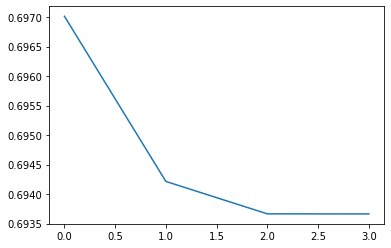

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [5]:
# So that works fairly well. I will now try doing the same thing using Huggingfaace

In [6]:
bert_model = None

In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=2, # we have a binary classification task
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
df = pd.read_csv("data/IMDB Dataset.csv")
reviews = df['review'].tolist()
labels = df['sentiment'].tolist()

In [11]:
from tqdm import tqdm

In [12]:
input_ids = []
attention_masks = []

for i in tqdm(range(len(reviews))):
    encoded_dict = tokenizer.encode_plus(
                        reviews[i],                      # review to encode
                        add_special_tokens = True,   # add [CLS] and [SEP] tokens
                        max_length = 512,             # truncate long reviews
                        pad_to_max_length = True,    # pad short reviews
                        return_attention_mask = True, # create attention masks
                        return_tensors = 'pt'         # return PyTorch tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)


  0%|          | 0/50000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 50000/50000 [05:58<00:00, 139.32it/s]


In [17]:
from torch.nn import CrossEntropyLoss
from transformers import BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional

In [14]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
labels = df['sentiment'].tolist()
labels = torch.tensor(labels)

In [15]:
input_ids

tensor([[ 101, 2028, 1997,  ...,    0,    0,    0],
        [ 101, 1037, 6919,  ...,    0,    0,    0],
        [ 101, 1045, 2245,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2572,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 2053, 2028,  ...,    0,    0,    0]])

In [52]:
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config, bert, classifier, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.config = config
        self.bert = bert
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = classifier
        # Changed this to boost model performance.
        #self.loss_class_weights = torch.tensor([0.5, 1]).to(device)

    def forward(self,
                input_ids: Optional[torch.Tensor] = None,
                attention_mask: Optional[torch.Tensor] = None,
                token_type_ids: Optional[torch.Tensor] = None,
                position_ids: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None,
                return_dict: Optional[bool] = None, 
                output_attentions=False):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            return_dict=return_dict,
            output_attentions=output_attentions
        )

        sequence_output = outputs[1]
        

        sequence_output = self.dropout(sequence_output)
        logits, cls_attentions = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            #print(logits.shape, labels.shape)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        all_outputs = SequenceClassifierOutput(loss=loss, logits=logits, 
                                            hidden_states=outputs.hidden_states,
                                            attentions=outputs.attentions)
        if output_attentions:
            all_outputs = (all_outputs, cls_attentions)
        return all_outputs

In [53]:
class LinearClassifierHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.Linear1 = nn.Linear(input_dim, output_dim)
        nn.init.xavier_uniform_(self.Linear1.weight.data)


    def forward(self, embeddings, attention_mask=None):
        attention_weights = None # Do not change this line

        x = self.Linear1(embeddings)
        output = x

        return output, attention_weights

In [54]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
import copy

In [55]:
model_name = "bert-base-uncased"
BERT_config = AutoConfig.from_pretrained(model_name)

In [56]:
BERT_model = AutoModel.from_pretrained(model_name, output_attentions = True)
# TO DO: Reduce the number of transformer layers from 12 to 3 by taking only the 
#        first 3 layers.
BERT_model.encoder.layer = BERT_model.encoder.layer[:3] 


bm = copy.deepcopy(BERT_model.encoder)
for i in range(3):
  #print("hi")
  bm = list(bm.children())[-1]

bm = list(bm.children())[0]
hidden_dims = bm.out_features
print(BERT_model)
# print(hidden_dims)
#hidden_dims = 768 ## change

# Here we create the models
num_labels = 2
linear_classifier = LinearClassifierHead(hidden_dims, num_labels)
sentiment_analyser = BertForSequenceClassification(BERT_config, 
                                                          BERT_model, 
                                                          linear_classifier, 
                                                          num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [59]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [62]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning rate
                  eps = 1e-8 # epsilon
                )

epochs = 1

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = sentiment_analyser

model.to(device)

for epoch in range(epochs):
    for t, batch in tqdm(enumerate(train_dataloader)):
        model.train()
        
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        model.zero_grad()
        
        outputs = model(input_ids=batch_input_ids,
                             token_type_ids=None,
                             attention_mask=batch_attention_masks,
                             labels=batch_labels)
        
        loss, logits = outputs.loss, outputs.logits
        
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()
    model.eval()
    val_loss, val_accuracy = 0, 0
    for batch in validation_dataloader:
        batch_input_ids = batch[0].to(device)
        batch_attention_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(batch_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=batch_attention_masks,
                                   labels=batch_labels)
            
        
        loss, logits = outputs.loss, outputs.logits
            
        val_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()
        preds = np.argmax(logits, axis=1)

        val_accuracy += np.sum(preds == label_ids)

    avg_val_loss = val_loss / len(validation_dataloader)
    avg_val_accuracy = val_accuracy / len(val_dataset)

    print(f'Epoch {epoch + 1} - validation loss: {avg_val_loss:.3f} - validation accuracy: {avg_val_accuracy:.3f}')

625it [14:53,  1.43s/it]


Epoch 1 - validation loss: 0.259 - validation accuracy: 0.895


In [ ]:
# Evidently this does even